In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pathlib

In [28]:
# Set dataset path
data_dir = pathlib.Path('cell_images')

# Verify dataset
image_count = len(list(data_dir.glob('*/*.png')))
print(f"Total images: {image_count}")
uninfected = list(data_dir.glob('Uninfected/*'))
parasitized = list(data_dir.glob('Parasitized/*'))
print(f"Number of Uninfected cells: {len(uninfected)}")
print(f"Number of Parasitized cells: {len(parasitized)}")

Total images: 27558
Number of Uninfected cells: 13780
Number of Parasitized cells: 13780


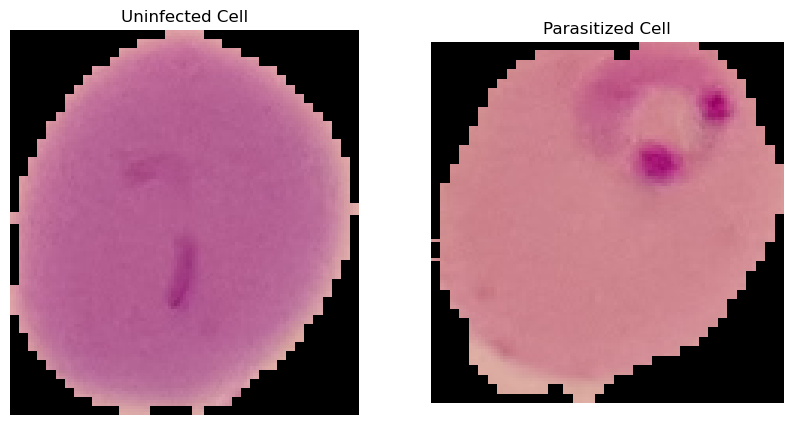

In [29]:
# Display sample images
try:
    img_uninfected = load_img(str(uninfected[0]))
    img_parasitized = load_img(str(parasitized[0]))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_uninfected)
    plt.title("Uninfected Cell")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(img_parasitized)
    plt.title("Parasitized Cell")
    plt.axis("off")
    plt.show()
except Exception as e:
    print(f"Error displaying sample images: {e}")

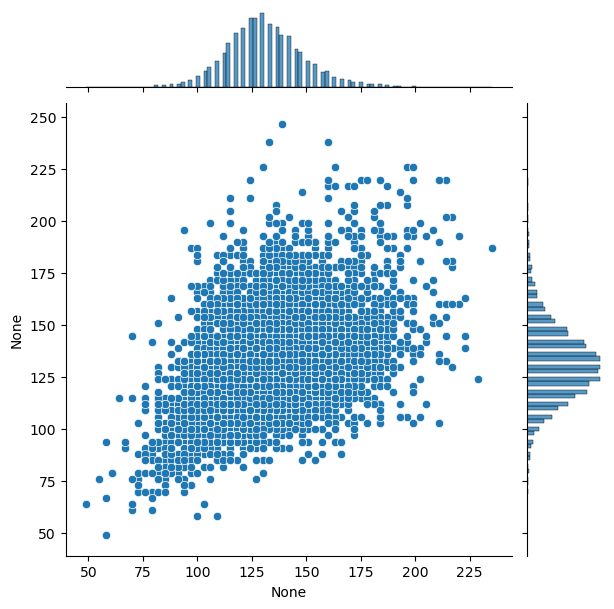

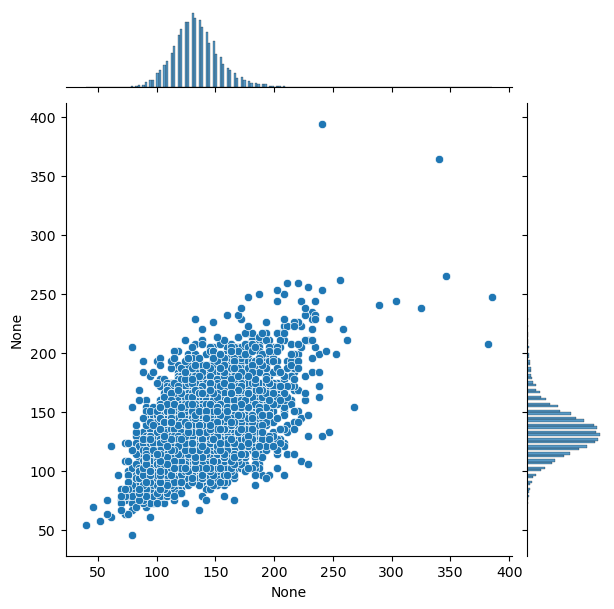

Uninfected mean dimensions: (131.58001306335728, 131.3424776834313)
Parasitized mean dimensions: (134.3868930981929, 133.6318310472458)


In [30]:
# Check image dimensions
def check_image_dimensions(directory):
    dim1, dim2 = [], []
    for image_file in os.listdir(directory):
        if not image_file.endswith(('jpg', 'jpeg', 'png', 'gif')):
            continue
        img = plt.imread(os.path.join(directory, image_file))
        d1, d2, *colors = img.shape
        dim1.append(d1)
        dim2.append(d2)
    sns.jointplot(x=dim1, y=dim2, kind="scatter")
    plt.show()
    return np.mean(dim1), np.mean(dim2)

uninfected_mean = check_image_dimensions('cell_images/Uninfected')
parasitized_mean = check_image_dimensions('cell_images/Parasitized')
print(f"Uninfected mean dimensions: {uninfected_mean}")
print(f"Parasitized mean dimensions: {parasitized_mean}")

In [31]:
# Define image shape
image_shape = (130, 130, 3)

# Data augmentation and generators
image_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.3
)

batch_size = 32  # Increased for efficiency

In [32]:
# Training data (70%)
train_data = image_gen.flow_from_directory(
    data_dir,
    subset='training',
    class_mode='binary',
    target_size=image_shape[:2],
    batch_size=batch_size,
    shuffle=True
)

# Validation data (30%)
val_data = image_gen.flow_from_directory(
    data_dir,
    subset='validation',
    class_mode='binary',
    target_size=image_shape[:2],
    batch_size=batch_size,
    shuffle=False
)

# Test data (sample from validation for evaluation)
test_data = image_gen.flow_from_directory(
    data_dir,
    subset='validation',
    class_mode='binary',
    target_size=image_shape[:2],
    batch_size=batch_size,
    shuffle=False
)

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


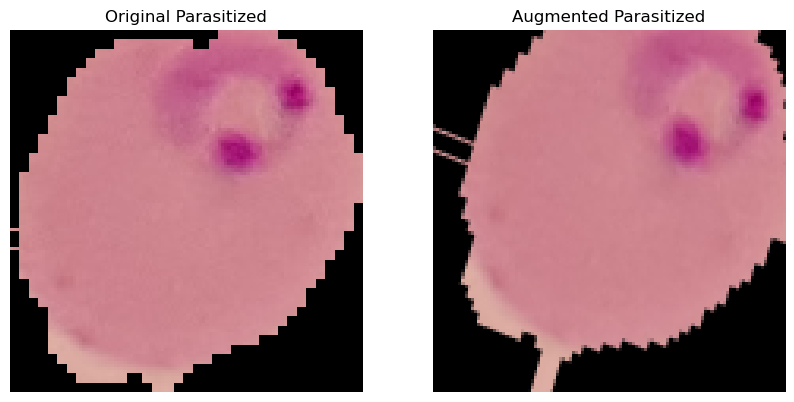

In [33]:
# Display sample augmentation
para_img = plt.imread(str(parasitized[0]))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(para_img)
plt.title("Original Parasitized")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image_gen.random_transform(para_img))
plt.title("Augmented Parasitized")
plt.axis("off")
plt.show()

In [34]:
# Build custom CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=image_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,849 (6.34 MB)

 Trainable params: 1,662,529 (6.34 MB)

 Non-trainable params: 320 (1.25 KB)

In [35]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("malaria_classifier.keras", monitor="val_loss", save_best_only=True, mode="min"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# Calculate steps per epoch
steps_per_epoch = train_data.samples // batch_size
validation_steps = val_data.samples // batch_size

In [36]:
# Train the model
import warnings
warnings.filterwarnings('ignore')
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 362s 598ms/step - accuracy: 0.6309 - loss: 1.0860 - val_accuracy: 0.7780 - val_loss: 0.8279 - learning_rate: 1.0000e-04
Epoch 2/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.6250 - loss: 1.0210 - val_accuracy: 0.7727 - val_loss: 0.8298 - learning_rate: 1.0000e-04
Epoch 3/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 337s 559ms/step - accuracy: 0.8193 - loss: 0.7432 - val_accuracy: 0.8778 - val_loss: 0.6331 - learning_rate: 1.0000e-04
Epoch 4/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.9375 - loss: 0.4874 - val_accuracy: 0.8811 - val_loss: 0.6259 - learning_rate: 1.0000e-04
Epoch 5/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 355s 589ms/step - accuracy: 0.8980 - loss: 0.5996 - val_accuracy: 0.9196 - val_loss: 0.5050 - learning_rate: 1.0000e-04
Epoch 6/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.8750 - loss: 0.5236 - val_accuracy: 0.9202 - val_loss: 0.5069 - learning_rate: 1.0000e-04
Epoch 7/25
602/602 ━━━━━━━━━━━━━━━━━━━━ 367s 6

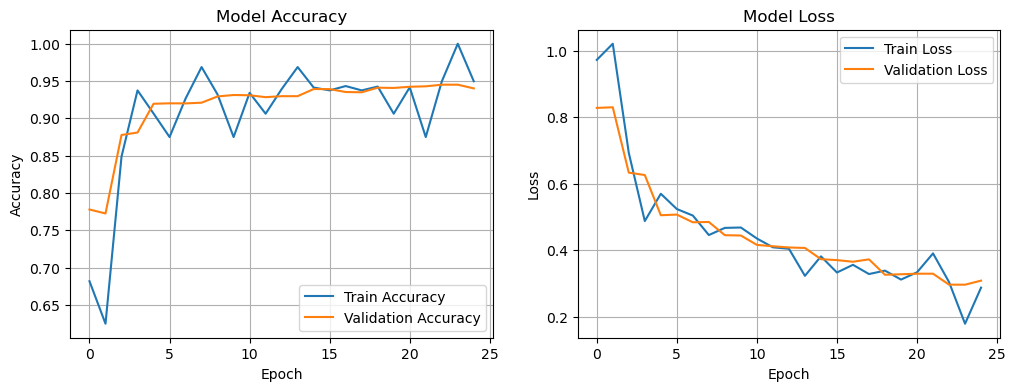

In [37]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_data, steps=test_data.samples // batch_size)
print(f"Test Accuracy: {test_accuracy:.4f}")

258/258 ━━━━━━━━━━━━━━━━━━━━ 43s 165ms/step - accuracy: 0.9357 - loss: 0.2979
Test Accuracy: 0.9443


In [42]:
# Classification report
preds = model.predict(test_data)
preds = (preds > 0.5).astype(int)
print(classification_report(test_data.classes, preds))

259/259 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4133
           1       0.94      0.95      0.95      4133

    accuracy                           0.95      8266
   macro avg       0.95      0.95      0.95      8266
weighted avg       0.95      0.95      0.95      8266



259/259 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step


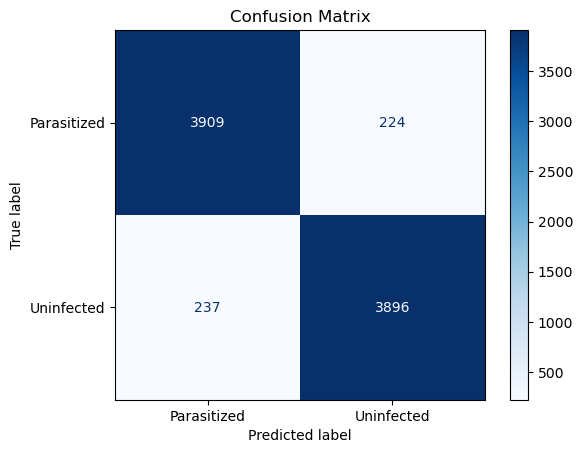

In [43]:
# Confusion matrix
y_pred_probs = model.predict(test_data)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred)
labels = list(test_data.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [49]:
# Predict on single images
def predict_image(img_path):
    img = load_img(img_path, target_size=image_shape[:2])
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]  # scalar between 0 and 1
    predicted_class = 1 if prediction > 0.5 else 0

    class_labels = list(test_data.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    print(f"Predicted Class: {predicted_label} (Confidence: {prediction:.4f})")
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_label}")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted Class: Uninfected (Confidence: 0.8418)


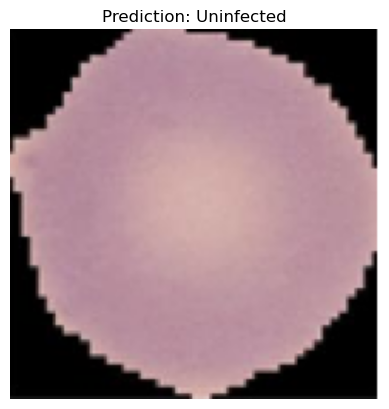

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Class: Parasitized (Confidence: 0.0000)


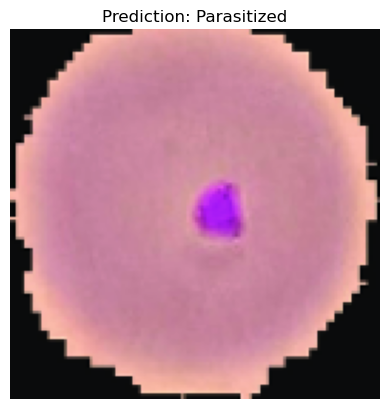

In [54]:
# Example predictions
predict_image('test_for_uninfected_cell.png')
predict_image('test_for_parasitized_cell.png')